In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string

from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.neural_network import MLPClassifier

import pickle
import cloudpickle


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('./email_spam_datset.csv')

In [4]:
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# DATA CLEANING

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
# renaming column names
df.rename(columns = {'Category':'target','Message':'message'},inplace=True)

In [7]:
df

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...
5571,ham,Rofl. Its true to its name


In [8]:
df['target'].unique()

array(['ham', 'spam', '{"mode":"full"'], dtype=object)

In [9]:
# removing rows where target is unknown
df = df.drop(df[df['target'] == '{"mode":"full"'].index)

In [10]:
df

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [11]:
# encoding the target column
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [12]:
df

,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [13]:
df.isnull().sum()

target     0
message    0
dtype: int64

In [14]:
df.duplicated().sum()

415

In [15]:
df.drop_duplicates(keep='first',inplace=True)

In [16]:
df

,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


<Axes: xlabel='message_length', ylabel='Count'>

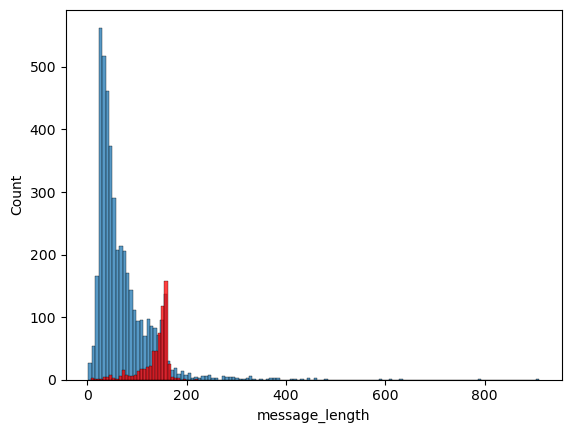

In [17]:
df['message_length'] = df['message'].apply(len)
sns.histplot(df[df['target'] == 0]['message_length'])
sns.histplot(df[df['target'] == 1]['message_length'],color='red')

In [18]:
df.drop(columns=['message_length'])

,target,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


# TEXT PREPROCESSING

In [19]:
nlp = spacy.load('en_core_web_sm')

def preprocess_text(text):
    # lowercasing
    text = text.lower()

    # tokenizing ( using spacy's pipeline )
    doc = nlp(text)

    # removing special characters, punctuations adn stop words
    tokens = [token for token in doc if token.is_alpha and token.text not in STOP_WORDS]

    # lemmitizing
    lemmatized_tokens = [token.lemma_ for token in tokens]

    # joining the tokens back in a string
    return ' '.join(lemmatized_tokens)

In [20]:
df['preprocessed_message'] = df['message'].apply(preprocess_text)

# EXPLORATORY DATA ANALYSIS

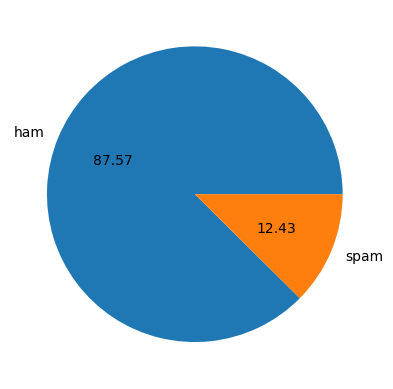

In [21]:
plt.pie(df['target'].value_counts(),labels = ['ham','spam'],autopct = '%0.2f');

In [22]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [23]:
spam_wc = wc.generate(df[df['target'] == 1]['preprocessed_message'].str.cat(sep=" "))

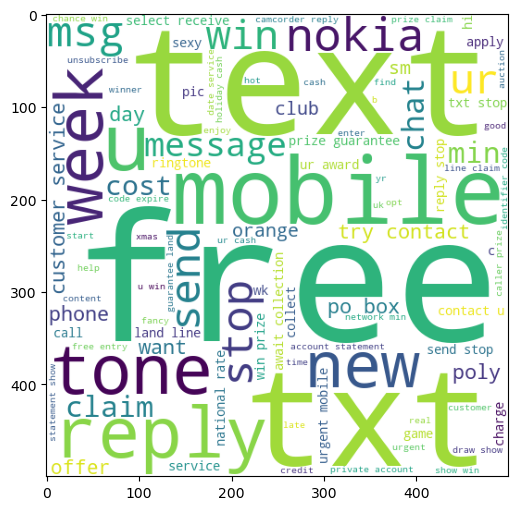

In [24]:
# spam word cloud
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [25]:
ham_wc = wc.generate(df[df['target'] == 0]['preprocessed_message'].str.cat(sep=" "))

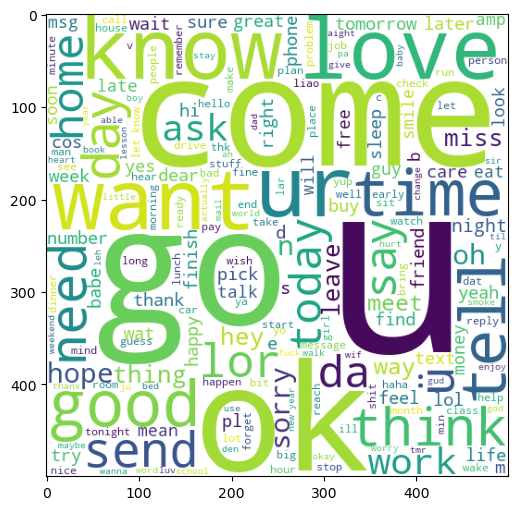

In [26]:
# ham word cloud
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [27]:
spam_words = ' '.join(df[df['target'] == 1]['preprocessed_message']).split()
non_spam_words = ' '.join(df[df['target'] == 0]['preprocessed_message']).split()

spam_word_count = Counter(spam_words).most_common(20)
non_spam_word_count = Counter(non_spam_words).most_common(20)

print("spam words",spam_word_count)
print("----------------------------------------------------------------------------------------------------------")
print("non spam words",non_spam_word_count)

spam words [('free', 189), ('txt', 134), ('text', 125), ('ur', 119), ('mobile', 114), ('u', 111), ('stop', 107), ('win', 100), ('reply', 100), ('claim', 96), ('prize', 78), ('send', 70), ('min', 69), ('new', 67), ('service', 65), ('cash', 64), ('tone', 64), ('urgent', 56), ('award', 55), ('week', 54)]
----------------------------------------------------------------------------------------------------------
non spam words [('u', 878), ('go', 308), ('come', 300), ('get', 295), ('not', 291), ('ok', 250), ('know', 247), ('good', 243), ('like', 232), ('want', 210), ('time', 207), ('love', 205), ('ur', 202), ('day', 201), ('tell', 184), ('think', 183), ('need', 172), ('send', 171), ('ü', 167), ('lor', 159)]


# MODEL BUILDING

In [28]:
# bag of words vectorizer
bow_vectorizer = CountVectorizer(max_features=3000)
X_bow = bow_vectorizer.fit_transform(df['preprocessed_message']).toarray()

In [29]:
# tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf_vectorizer.fit_transform(df['preprocessed_message']).toarray()

In [30]:
y = df['target'].values

In [31]:
# using following classifiers
classifiers = {
    "Naive Bayes": MultinomialNB(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernolli Naive Bayes": BernoulliNB(),
    "Logistic Regression": LogisticRegression(random_state = 2024),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state = 2024),
    "Random Forest": RandomForestClassifier(random_state = 2024),
    "Multi Layer Perceptron": MLPClassifier(random_state = 2024)
}

In [32]:
def evaluate_model(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, 'predict_proba') else None

    # Defining all metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted'),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted')
    }
    
    if y_proba is not None:
        metrics["ROC AUC"] = roc_auc_score(y_test, y_proba, average='weighted')

    return metrics

In [33]:
# Splitting the data
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=2024)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=2024)

In [34]:
print(X_train_tfidf.shape)

(4125, 3000)


In [35]:
stored_models = {}
results = {}

# Evaluation with Bag of Words
for clf_name, clf in classifiers.items():
    result_key = f"Bag of Words + {clf_name}"
    results[result_key] = evaluate_model(clf, X_train_bow, X_test_bow, y_train, y_test)
    stored_models[result_key] = clf

# Evaluation with TF-IDF
for clf_name, clf in classifiers.items():
    result_key = f"TF-IDF + {clf_name}"
    results[result_key] = evaluate_model(clf, X_train_tfidf, X_test_tfidf, y_train, y_test)
    stored_models[result_key] = clf

In [36]:
results_df = pd.DataFrame(results).T

In [37]:
results_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Bag of Words + Naive Bayes,0.969961,0.970705,0.969961,0.970251,0.980753
Bag of Words + Gaussian Naive Bayes,0.832364,0.894890,0.832364,0.851001,0.834187
Bag of Words + Bernolli Naive Bayes,0.963178,0.962814,0.963178,0.961659,0.986233
Bag of Words + Logistic Regression,0.968023,0.968001,0.968023,0.966760,0.986225
Bag of Words + SVM,0.963178,0.964265,0.963178,0.960976,0.977639
Bag of Words + KNN,0.908915,0.917660,0.908915,0.889806,0.804889
Bag of Words + Decision Tree,0.959302,0.958452,0.959302,0.958700,0.905354
Bag of Words + Random Forest,0.968023,0.968001,0.968023,0.966760,0.981460
Bag of Words + Multi Layer Perceptron,0.969961,0.969452,0.969961,0.969280,0.978447
TF-IDF + Naive Bayes,0.960271,0.961136,0.960271,0.957818,0.981613


# Storing the Final Model

In [38]:
#Final selection: Bag of Words + MLP
cloudpickle.dump(preprocess_text,open('preprocess_text.pkl','wb'))
pickle.dump(bow_vectorizer,open('bow_vectorizer.pkl','wb'))
pickle.dump(stored_models['Bag of Words + Multi Layer Perceptron'],open('model.pkl','wb'))